# 知识表示：电影推荐实验


## 数据和模型概览: 

- 数据提供（UserID，MovieID）组对，每个这样的组对，对应了一个 “标签”，帮助告诉模型用户和电影是否相似

     * 当标签为一个数值时，我们可用模型来预测指定用户对指定电影的评分
     * 当标签为二进制时，我们可用模型向用户推荐电影

- 下图显示了*Object2Vec*模型可使用数据集提供的`(UserID, ItemID, Rating)` 样本数据，解决预测影片评分这个问题。在这里，评分是真实数值。当然，我们也可以把评分处理成二进制，方便后面的影片推荐

<img style="float:middle" src="image_ml_rating.png" width="480">

### 数据集

我们将使用MovieLens上拥有10 万条数据的数据集： https://grouplens.org/datasets/movielens/100k/

### 应用场景

- 任务 1：影片推荐模型训练（Object2Vec + 分类）
- 任务 2：通过模型找到向量空间中的相似影片

### 在运行notebook之前

- 请选择Python 3的kernel（核）
- 请确保你安装了`jsonlines` 包，若还没有可以通过下面的指令安装

In [1]:
!pip install jsonlines

You are using pip version 10.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import sys
import csv, jsonlines
import numpy as np
import copy
import random

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# 数据探索及准备

### 数据使用许可

请仔细阅读 [data set description page](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt)相关描述，此数据仅可用于研究和教学用途，不可用于商业用途。
有进一步问题请联系 GroupLens \<grouplens-info@cs.umn.edu\>。

In [4]:
%%bash

curl -o ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
unzip ml-100k.zip
rm ml-100k.zip

Archive:  ml-100k.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  9283k      0 --:--:-- --:--:-- --:--:-- 9283k
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: replace k.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


### 让我们首先创建一些用于数据探索和预处理的实用工具函数

In [5]:
## 准备些实用工具程序

def load_csv_data(filename, delimiter, verbose=True):
    """
    input: a file readable as csv and separated by a delimiter
    and has format users - movies - ratings - etc
    output: a list, where each row of the list is of the form
    {'in0':userID, 'in1':movieID, 'label':rating}
    """
    to_data_list = list()
    users = list()
    movies = list()
    ratings = list()
    unique_users = set()
    unique_movies = set()
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            #if count!=0:
            to_data_list.append({'in0':[int(row[0])], 'in1':[int(row[1])], 'label':float(row[2])})
            users.append(row[0])
            movies.append(row[1])
            ratings.append(float(row[2]))
            unique_users.add(row[0])
            unique_movies.add(row[1])
    if verbose:
        print("In file {}, there are {} ratings".format(filename, len(ratings)))
        print("The ratings have mean: {}, median: {}, and variance: {}".format(
                                            round(np.mean(ratings), 2), 
                                            round(np.median(ratings), 2), 
                                            round(np.var(ratings), 2)))
        print("There are {} unique users and {} unique movies".format(len(unique_users), len(unique_movies)))
    return to_data_list


def csv_to_augmented_data_dict(filename, delimiter):
    """
    Input: a file that must be readable as csv and separated by delimiter (to make columns)
    has format users - movies - ratings - etc
    Output:
      Users dictionary: keys as user ID's; each key corresponds to a list of movie ratings by that user
      Movies dictionary: keys as movie ID's; each key corresponds a list of ratings of that movie by different users
    """
    to_users_dict = dict() 
    to_movies_dict = dict()
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            #if count!=0:
            if row[0] not in to_users_dict:
                to_users_dict[row[0]] = [(row[1], row[2])]
            else:
                to_users_dict[row[0]].append((row[1], row[2]))
            if row[1] not in to_movies_dict:
                to_movies_dict[row[1]] = list(row[0])
            else:
                to_movies_dict[row[1]].append(row[0])
    return to_users_dict, to_movies_dict


def user_dict_to_data_list(user_dict):
    # turn user_dict format to data list format (acceptable to the algorithm)
    data_list = list()
    for user, movie_rating_list in user_dict.items():
        for movie, rating in movie_rating_list:
            data_list.append({'in0':[int(user)], 'in1':[int(movie)], 'label':float(rating)})
    return data_list

def divide_user_dicts(user_dict, sp_ratio_dict):
    """
    Input: A user dictionary, a ration dictionary
         - format of sp_ratio_dict = {'train':0.8, "test":0.2}
    Output: 
        A dictionary of dictionaries, with key corresponding to key provided by sp_ratio_dict
        and each key corresponds to a subdivded user dictionary
    """
    ratios = [val for _, val in sp_ratio_dict.items()]
    assert np.sum(ratios) == 1, "the sampling ratios must sum to 1!"
    divided_dict = {}
    for user, movie_rating_list in user_dict.items():
        sub_movies_ptr = 0
        sub_movies_list = []
        #movie_list, _ = zip(*movie_rating_list)
        #print(movie_list)
        for i, ratio in enumerate(ratios):
            if i < len(ratios)-1:
                sub_movies_ptr_end = sub_movies_ptr + int(len(movie_rating_list)*ratio)
                sub_movies_list.append(movie_rating_list[sub_movies_ptr:sub_movies_ptr_end])
                sub_movies_ptr = sub_movies_ptr_end
            else:
                sub_movies_list.append(movie_rating_list[sub_movies_ptr:])
        for subset_name in sp_ratio_dict.keys():
            if subset_name not in divided_dict:
                divided_dict[subset_name] = {user: sub_movies_list.pop(0)}
            else:
                #access sub-dictionary
                divided_dict[subset_name][user] = sub_movies_list.pop(0)
    
    return divided_dict

def write_csv_to_jsonl(jsonl_fname, csv_fname, csv_delimiter):
    """
    Input: a file readable as csv and separated by delimiter (to make columns)
        - has format users - movies - ratings - etc
    Output: a jsonline file converted from the csv file
    """
    with jsonlines.open(jsonl_fname, mode='w') as writer:
        with open(csv_fname, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=csv_delimiter)
            for count, row in enumerate(reader):
                #print(row)
                #if count!=0:
                writer.write({'in0':[int(row[0])], 'in1':[int(row[1])], 'label':float(row[2])})
        print('Created {} jsonline file'.format(jsonl_fname))
                    
    
def write_data_list_to_jsonl(data_list, to_fname):
    """
    Input: a data list, where each row of the list is a Python dictionary taking form
    {'in0':userID, 'in1':movieID, 'label':rating}
    Output: save the list as a jsonline file
    """
    with jsonlines.open(to_fname, mode='w') as writer:
        for row in data_list:
            #print(row)
            writer.write({'in0':row['in0'], 'in1':row['in1'], 'label':row['label']})
    print("Created {} jsonline file".format(to_fname))

def data_list_to_inference_format(data_list, binarize=True, label_thres=3):
    """
    Input: a data list
    Output: test data and label, acceptable by SageMaker for inference
    """
    data_ = [({"in0":row['in0'], 'in1':row['in1']}, row['label']) for row in data_list]
    data, label = zip(*data_)
    infer_data = {"instances":data}
    if binarize:
        label = get_binarized_label(list(label), label_thres)
    return infer_data, label


def get_binarized_label(data_list, thres):
    """
    Input: data list
    Output: a binarized data list for recommendation task
    """
    for i, row in enumerate(data_list):
        if type(row) is dict:
            #if i < 10:
                #print(row['label'])
            if row['label'] > thres:
                #print(row)
                data_list[i]['label'] = 1
            else:
                data_list[i]['label'] = 0
        else:
            if row > thres:
                data_list[i] = 1
            else:
                data_list[i] = 0
    return data_list


In [6]:
## 导入数据并进行随机打乱处理
prefix = 'ml-100k'
train_path = os.path.join(prefix, 'ua.base')
valid_path = os.path.join(prefix, 'ua.test')
test_path = os.path.join(prefix, 'ub.test')

train_data_list = load_csv_data(train_path, '\t')
random.shuffle(train_data_list)
validation_data_list = load_csv_data(valid_path, '\t')
random.shuffle(validation_data_list)

In file ml-100k/ua.base, there are 90570 ratings
The ratings have mean: 3.52, median: 4.0, and variance: 1.27
There are 943 unique users and 1680 unique movies
In file ml-100k/ua.test, there are 9430 ratings
The ratings have mean: 3.59, median: 4.0, and variance: 1.25
There are 943 unique users and 1129 unique movies


In [7]:
to_users_dict, to_movies_dict = csv_to_augmented_data_dict(train_path, '\t')

### 接下来，我们来做一些数据探索


The min, max, and median 'movies per user' is 10, 727, and 55.0
The min, max, and median 'users per movie' is 1, 495, and 25.0
In the training set
There are 213 users with no more than 20 movies
There are 12 movies with no more than 2 user


Text(0.5, 1.0, 'Users per movie')

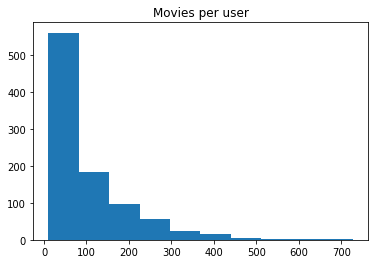

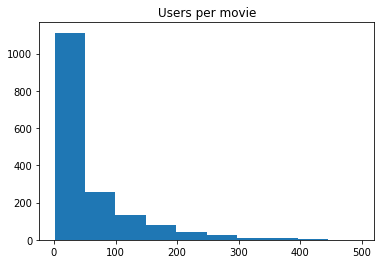

In [8]:
## 计算每个人看的电影数量的最小值，最大值，中位数
movies_per_user = [len(val) for key, val in to_users_dict.items()]

print("The min, max, and median 'movies per user' is {}, {}, and {}".format(np.amin(movies_per_user),
                                                                         np.amax(movies_per_user),
                                                                         np.median(movies_per_user)))
users_per_movie = [len(val) for key, val in to_movies_dict.items()]
print("The min, max, and median 'users per movie' is {}, {}, and {}".format(np.amin(users_per_movie),
                                                                         np.amax(users_per_movie),
                                                                          np.median(users_per_movie)))


count = 0
n_movies_lower_bound = 20
for n_movies in movies_per_user:
    if n_movies <= n_movies_lower_bound:
        count += 1
print("In the training set")
print('There are {} users with no more than {} movies'.format(count, n_movies_lower_bound))
#
count = 0
n_users_lower_bound = 2
for n_users in users_per_movie:
    if n_users <= n_users_lower_bound:
        count += 1
print('There are {} movies with no more than {} user'.format(count, n_users_lower_bound))


## 画图

f = plt.figure(1)
plt.hist(movies_per_user)
plt.title("Movies per user")
##
g = plt.figure(2)
plt.hist(users_per_movie)
plt.title("Users per movie")

#### 由于一个观众观看少于3个电影的情况占总数的比例非常小，可忽略不计，因此我们不会从数据集中删除这些数据；这个道理同样适用于电影被多少个观众看这个场景

In [9]:
## 在本地保存训练数据集和验证数据集，供后面的评分预测任务（回归）使用

write_data_list_to_jsonl(copy.deepcopy(train_data_list), 'train_r.jsonl')
write_data_list_to_jsonl(copy.deepcopy(validation_data_list), 'validation_r.jsonl')

Created train_r.jsonl jsonline file
Created validation_r.jsonl jsonline file


In [10]:
## 在本地保存训练数据集和验证数据集，供后面的推荐任务（分类）使用

### 将数据二进制化（1或0）

train_c = get_binarized_label(copy.deepcopy(train_data_list), 3.0)
valid_c = get_binarized_label(copy.deepcopy(validation_data_list), 3.0)

write_data_list_to_jsonl(train_c, 'train_c.jsonl')
write_data_list_to_jsonl(valid_c, 'validation_c.jsonl')

Created train_c.jsonl jsonline file
Created validation_c.jsonl jsonline file


#### 我们来检查下这两个分类的数据集在二进制化后，数据是否平衡

In [11]:
train_c_label = [row['label'] for row in train_c]
valid_c_label = [row['label'] for row in valid_c]

print("There are {} fraction of positive ratings in train_c.jsonl".format(
                                np.count_nonzero(train_c_label)/len(train_c_label)))
print("There are {} fraction of positive ratings in validation_c.jsonl".format(
                                np.sum(valid_c_label)/len(valid_c_label)))

There are 0.5510213094843768 fraction of positive ratings in train_c.jsonl
There are 0.5799575821845175 fraction of positive ratings in validation_c.jsonl


## 模型训练和推理

#### 定义一个用来存储数据和模型的 S3 存储桶，并将数据上传到这个 存储桶


In [12]:
import boto3 
import os
 
bucket = 'movie-rec' # 填写你的S3桶的名称
input_prefix = 'object2vec/movielens/input'
output_prefix = 'object2vec/movielens/output'

#### 将数据上传至S3并建立相关数据存储路径

In [13]:
from sagemaker.session import s3_input

s3_client = boto3.client('s3')
input_paths = {}
output_path = os.path.join('s3://', bucket, output_prefix)

for data_name in ['train', 'validation']:
    pre_key = os.path.join(input_prefix, 'rating', f'{data_name}')
    fname = '{}_r.jsonl'.format(data_name)
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded {} data to {} and defined input path'.format(data_name, data_path))

print('Trained model will be saved at', output_path)

Uploaded train data to s3://movie-rec/object2vec/movielens/input/rating/train/train_r.jsonl and defined input path
Uploaded validation data to s3://movie-rec/object2vec/movielens/input/rating/validation/validation_r.jsonl and defined input path
Trained model will be saved at s3://movie-rec/object2vec/movielens/output


### 获取Object2Vec的算法镜像

In [14]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

role = get_execution_role()
print(role)

## 获取ObjectToVec算法的docker镜像
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'object2vec')

arn:aws:iam::130589633421:role/service-role/AmazonSageMaker-ExecutionRole-20200218T140233


# 推荐任务

#### 下面，我们将展示如何通过Object2Vec，使用二进制评级标签来推荐电影。在这里，如果给定用户的电影评分标签将被进行二进制处理，标签评分为‘1’则表示应向用户推荐该影片，标签评分为 ‘0’则表示不应向用户推荐该影片。我们将调用二进制数据集预处理的函数进行评分标签的转换。

#### 我们将二进制的数据集上传至S3，再进行下一步的分类模型的训练

In [15]:
for data_name in ['train', 'validation']:
    fname = '{}_c.jsonl'.format(data_name)
    pre_key = os.path.join(input_prefix, 'recommendation', f"{data_name}")
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded data to {}'.format(data_path))

Uploaded data to s3://movie-rec/object2vec/movielens/input/recommendation/train/train_c.jsonl
Uploaded data to s3://movie-rec/object2vec/movielens/input/recommendation/validation/validation_c.jsonl


#### 我们刚才已经获取了算法的镜像，现在可以开始训练模型了

In [16]:
from sagemaker.session import s3_input

hyperparameters_c = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3, 
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_cnn_filter_width": 3,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 2048,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 2048,
    "mlp_activation": "relu",
    "mlp_dim": 1024,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "softmax"
}

In [17]:
from sagemaker.predictor import json_serializer, json_deserializer

## 获取推算器
classifier = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## 代入设置好的高参数
classifier.set_hyperparameters(**hyperparameters_c)

## 训练，调整，测试模型
classifier.fit(input_paths)

2020-05-22 05:17:54 Starting - Starting the training job...
2020-05-22 05:17:57 Starting - Launching requested ML instances.........
2020-05-22 05:19:39 Starting - Preparing the instances for training......
2020-05-22 05:20:51 Downloading - Downloading input data...
2020-05-22 05:21:03 Training - Downloading the training image......
2020-05-22 05:22:12 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/22/2020 05:22:15 INFO 140234599638848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embe

[05/22/2020 05:22:24 INFO 140234599638848] arg_params keys for module initialization: []
[05/22/2020 05:22:24 INFO 140234599638848] all params:['output_layer_weight', 'mlp_fc0_weight', 'mlp_fc0_bias', 'output_layer_bias', 'embed_1_weight', 'embed_0_weight']
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 5587.174892425537, "sum": 5587.174892425537, "min": 5587.174892425537}}, "EndTime": 1590124944.461489, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "ObjectToVec"}, "StartTime": 1590124935.950809}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "ma

[05/22/2020 05:22:46 INFO 140234599638848] **************
[05/22/2020 05:22:46 INFO 140234599638848] Completed Epoch: 4, time taken: 0:00:04.216339
[05/22/2020 05:22:46 INFO 140234599638848] Epoch 4 Training metrics:   perplexity: 1.079 cross_entropy: 0.076 accuracy: 0.980 
[05/22/2020 05:22:46 INFO 140234599638848] #quality_metric: host=algo-1, epoch=4, train cross_entropy <loss>=0.0764139492479
[05/22/2020 05:22:46 INFO 140234599638848] #quality_metric: host=algo-1, epoch=4, train accuracy <score>=0.979568142361
[05/22/2020 05:22:46 INFO 140234599638848] Epoch 4 Validation metrics: perplexity: 2.601 cross_entropy: 0.956 accuracy: 0.693 
[05/22/2020 05:22:46 INFO 140234599638848] #quality_metric: host=algo-1, epoch=4, validation cross_entropy <loss>=0.955849802494
[05/22/2020 05:22:46 INFO 140234599638848] #quality_metric: host=algo-1, epoch=4, validation accuracy <score>=0.693359375
[05/22/2020 05:22:46 INFO 140234599638848] **************
[05/22/2020 05:22:46 INFO 140234599638848] p


2020-05-22 05:22:58 Uploading - Uploading generated training model
2020-05-22 05:23:30 Completed - Training job completed
Training seconds: 159
Billable seconds: 159


#### 模型训练完后，我们来用测试数据集再来验证一遍模型的准确率

In [18]:
classification_model = classifier.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')

predictor = classification_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------------!

In [19]:
valid_c_data, valid_c_label = data_list_to_inference_format(copy.deepcopy(validation_data_list), 
                                                            label_thres=3, binarize=True)
predictions = predictor.predict(valid_c_data)

In [20]:
def get_class_accuracy(res, labels, thres):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    accuracy = 0
    for row, label in zip(res, labels):
        if type(row) is dict:
            if row['scores'][1] > thres:
                prediction = 1
            else: 
                prediction = 0
            if label > thres:
                label = 1
            else:
                label = 0
            accuracy += 1 - (prediction - label)**2
    return accuracy / float(len(res))

print("The accuracy on the binarized validation set is %.3f" %get_class_accuracy(predictions, valid_c_label, 0.5))

The accuracy on the binarized validation set is 0.701


#### 测试数据集里测出来的模型准确率应该在0.7左右

## 进行电影推荐

由于 *Object2Vec* 在训练过程中将用户ID和影片ID转换为向量内容。训练后，它分别在左侧和右侧编码器中获取用户和电影的向量。简单来讲，算法将这些内容和关系调整为向量表示，以便于接下来进行监督学习任务。因为对于特定用户而言，类似的电影应该具有类似的评分，我们期望类似的电影在向量空间中处于 **相近** 的位置。

下面，我们将演示如何在所有影片ID中找到指定影片ID的最邻近（欧式距离）。


In [21]:
def get_movie_embedding_dict(movie_ids, trained_model):
    input_instances = list()
    for s_id in movie_ids:
        input_instances.append({'in1': [s_id]})
    data = {'instances': input_instances}
    movie_embeddings = trained_model.predict(data)
    embedding_dict = {}
    for s_id, row in zip(movie_ids, movie_embeddings['predictions']):
        embedding_dict[s_id] = np.array(row['embeddings'])
    return embedding_dict


def load_movie_id_name_map(item_file):
    movieID_name_map = {}
    with open(item_file, 'r', encoding="ISO-8859-1") as f:
        for row in f.readlines():
            row = row.strip()
            split = row.split('|')
            movie_id = split[0]
            movie_name = split[1]
            sparse_tags = split[-19:]
            movieID_name_map[int(movie_id)] = movie_name 
    return movieID_name_map

            
def get_nn_of_movie(movie_id, candidate_movie_ids, embedding_dict):
    movie_emb = embedding_dict[movie_id]
    min_dist = float('Inf')
    best_id = candidate_movie_ids[0]
    for idx, m_id in enumerate(candidate_movie_ids):
        candidate_emb = embedding_dict[m_id]
        curr_dist = np.linalg.norm(candidate_emb - movie_emb)
        if curr_dist < min_dist:
            best_id = m_id
            min_dist = curr_dist
    return best_id, min_dist


def get_unique_movie_ids(data_list):
    unique_movie_ids = set()
    for row in data_list:
        unique_movie_ids.add(row['in1'][0])
    return list(unique_movie_ids)

In [22]:
train_data_list = load_csv_data(train_path, '\t', verbose=False)
unique_movie_ids = get_unique_movie_ids(train_data_list)
embedding_dict = get_movie_embedding_dict(unique_movie_ids, predictor)
candidate_movie_ids = unique_movie_ids.copy()

#### 使用下面的脚本，你可以查看与数据集中任何影片最接近的影片。比如，在向量空间中找到最接近的电影 `终结者（1984）` 是 `侏罗纪公园 (1988)`  。

- 只需输入要检索的电影 ID ，例如，`终结者（1984）` 影片 ID 为 195；你可以在 `u.item` 文件中找到影片名称和 ID的成对组合
- 请注意，由于模型初始化的随机性，你的运行结果可能会有所不同

In [23]:
movie_id_to_examine = 195 # 填入你想要测试的电影ID号

In [24]:
candidate_movie_ids.remove(movie_id_to_examine)
best_id, min_dist = get_nn_of_movie(movie_id_to_examine, candidate_movie_ids, embedding_dict)
movieID_name_map = load_movie_id_name_map('ml-100k/u.item')
print('The closest movie to {} in the embedding space is {}'.format(movieID_name_map[movie_id_to_examine],
                                                                  movieID_name_map[best_id]))
candidate_movie_ids.append(movie_id_to_examine)

The closest movie to Terminator, The (1984) in the embedding space is Jurassic Park (1993)


#### 学习完毕后，建议删除用于托管模型的终端节点，避免云资源的浪费

In [25]:
## 清理终端节点
sess.delete_endpoint(predictor.endpoint)